In [68]:
import os
import cv2
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from facebookTimesformer.TimeSformer.models.vit import TimeSformer
from facebookTimesformer.TimeSformer.datasets.utils import tensor_normalize
from torch.utils.tensorboard import SummaryWriter
import sklearn
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [134]:
viratPath = os.path.join('static', 'VIRAT')
testVideoName = 'VIRAT_S_000102.txt'

In [135]:
dataMean = [0.45, 0.45, 0.45]
dataStd = [0.225, 0.225, 0.225]

embeddingsSize = 768
secondsPerAction = 7
framesPerVideo = 8
batchSize = 1

In [136]:
class EventInfo():
    def __init__(self, eventType, duration, startFrame, endFrame, framesDict):
        self.eventType = int(eventType)
        self.duration = int(duration)
        self.startFrame = int(startFrame)
        self.endFrame = int(endFrame)
        self.framesDict = framesDict
        self.leftTopX = 10000
        self.leftTopY = 10000
        self.rightBottomX = 0
        self.rightBottomY = 0

In [137]:
def getLabels(labelNames):
    eventLabelDict = {}
    for labelName in labelNames:
        videoName = labelName.split('.')[0]
            
        f = open(os.path.join(viratPath, 'labels', labelName))
        label = f.read().split('\n')[:-1]
        f.close()
        label = [l.split(' ')[:-1] for l in label]
        label = [[int(l1) for l1 in l] for l in label]
                
        for l in label:
            eventName = videoName + '.' + str(l[0])
            if eventName not in eventLabelDict:
                eventLabelDict[eventName] = EventInfo(l[1], l[2], l[3], l[4], dict())
            eventLabelDict[eventName].framesDict[l[5]] = [e for e in l[6:]]
            
    return eventLabelDict

In [138]:
trainLabels = getLabels([v for v in sorted(os.listdir(os.path.join(viratPath, 'labels'))) if not v.startswith(testVideoName)])
testLabels = getLabels([testVideoName])

In [139]:
def findClosest(indexList, i):
    #print('Closest to ' + str(i) + ' is ' + str(min(indexList, key=lambda x:abs(x-i))))
    return min(indexList, key=lambda x:abs(x-i))

In [140]:
idMax = max([int(t.split('.')[-1]) for t in trainLabels])
if idMax < max([int(t.split('.')[-1]) for t in testLabels]):
    idMax = max([int(t.split('.')[-1]) for t in testLabels])

In [141]:
def getCroppedClips(labels, splitClips=False):

    clips = []
    clipLabels = []

    for videoName in sorted(os.listdir(os.path.join(viratPath, 'videos'))):
        video = cv2.VideoCapture(os.path.join(viratPath, 'videos', videoName))
        video.set(cv2.CAP_PROP_POS_FRAMES, 0)
        success, image = video.read()
        actionLength = video.get(cv2.CAP_PROP_FPS) * secondsPerAction
        
        if splitClips:
            events = {}
            idNewAmount = 0
            for key, val in labels.items():
                if key.split('.')[0] == videoName.split('.')[0]:
                    currentStart = val.startFrame
                    while currentStart < val.endFrame:
                        idNewAmount += 1
                        print('id %d has length %d, startFrame %d, endFrame %d' % (idMax + idNewAmount, min(val.endFrame - currentStart, actionLength), currentStart, min(currentStart + actionLength, val.endFrame)))
                        events[idMax + idNewAmount] = EventInfo(val.eventType, 
                                                                min(val.endFrame - currentStart, actionLength),
                                                                currentStart,
                                                                min(currentStart + actionLength, val.endFrame),
                                                                {k:v for k, v in val.framesDict.items() if k >= currentStart and k <= currentStart + actionLength})
                        
                        if len(events[idMax + idNewAmount].framesDict) == 0:
                            if val.endFrame - currentStart <= currentStart - val.startFrame:
                                events[idMax + idNewAmount].framesDict[currentStart] = val.framesDict[val.endFrame]
                                events[idMax + idNewAmount].framesDict[currentStart + actionLength] = val.framesDict[val.endFrame]
                            else:
                                events[idMax + idNewAmount].framesDict[currentStart] = val.framesDict[val.startFrame]
                                if val.endFrame - currentStart - actionLength <= currentStart - val.startFrame + actionLength:
                                    events[idMax + idNewAmount].framesDict[currentStart + actionLength] = val.framesDict[val.endFrame]
                                else:
                                    events[idMax + idNewAmount].framesDict[currentStart + actionLength] = val.framesDict[val.startFrame]
                                
                        currentStart += actionLength
        else:
            events = {key:val for key, val in labels.items() if key.split('.')[0] == videoName.split('.')[0]} 
        
        for k in events:
            print("Processing eventID %s" % k)
            clip = torch.zeros((framesPerVideo, 224, 224, 3), dtype = torch.uint8)
            frameNumbers = [round(events[k].startFrame + i * (events[k].duration - 1.0) / (framesPerVideo - 1)) for i in range(framesPerVideo)]
            frameNumbers = [findClosest(events[k].framesDict.keys(), i) for i in frameNumbers]
            #print(frameNumbers)

            for i, n in enumerate(frameNumbers):
                xmin, ymin, xlen, ylen = events[k].framesDict[n]  
                #print(xmin, ymin, xlen, ylen)
                
                if xmin < events[k].leftTopX:
                    events[k].leftTopX = xmin
                if ymin < events[k].leftTopY:
                    events[k].leftTopY = ymin
                
                if xmin + xlen > events[k].rightBottomX:
                    events[k].rightBottomX = xmin + xlen
                if ymin + ylen > events[k].rightBottomY:
                    events[k].rightBottomY = ymin + ylen
            
            #print("(" + str(events[k].leftTopX) + ", " + str(events[k].leftTopY) + ") (" + str(events[k].rightBottomX) + ", " + str(events[k].rightBottomY) + ")")
            #print(str(events[k].duration) + " frames")
            
            for i, n in enumerate(frameNumbers):
                
                video.set(cv2.CAP_PROP_POS_FRAMES, n)
                success, image = video.read()
                if success:
                    bbox = image[max(events[k].leftTopY, 0) : events[k].rightBottomY, max(events[k].leftTopX, 0) : events[k].rightBottomX]
                    
                    clip[i] = torch.from_numpy(cv2.resize(bbox, (224, 224)))

                    '''if i == len(frameNumbers) - 1:
                        fig, ax = plt.subplots(figsize=(8, 6))
                        
                        clipMedian = np.zeros((3, 224, 224), dtype = np.int32)
                        for f in clip:
                            clipMedian += f
                        clipMedian = clipMedian / len(frameNumbers)
                        clipMedian = np.swapaxes(np.swapaxes(clipMedian, 0, 2), 0, 1)
                        
                        ax.imshow(clipMedian.astype(int))
                        #rect = mpatches.Rectangle((labelInfo[k].leftTopX, labelInfo[k].leftTopY), 
                        #              labelInfo[k].rightBottomX - labelInfo[k].leftTopX, labelInfo[k].rightBottomY - labelInfo[k].leftTopY,
                        #              fill=False, edgecolor='red', linewidth=2)
                        #ax.add_patch(rect)
                        ax.set_axis_off()
                        plt.tight_layout()
                        plt.show()'''

                else:
                    print('Error while reading frame %d in video %s' % (n, videoName))

            clips.append(clip)
            clipLabels.append(events[k].eventType)
            
    return (clips, clipLabels)

In [142]:
trainX, trainY = getCroppedClips(trainLabels)

Processing eventID VIRAT_S_010000_01_000184_000324.2
Processing eventID VIRAT_S_010000_01_000184_000324.3
Processing eventID VIRAT_S_010201_07_000601_000697.4
Processing eventID VIRAT_S_010202_06_000784_000873.5
Processing eventID VIRAT_S_010202_06_000784_000873.6
Processing eventID VIRAT_S_010203_06_000620_000760.7


In [143]:
testX, _ = getCroppedClips(testLabels, splitClips=True)

id 8 has length 209, startFrame 0, endFrame 209
id 9 has length 209, startFrame 209, endFrame 419
id 10 has length 209, startFrame 419, endFrame 629
id 11 has length 209, startFrame 629, endFrame 839
id 12 has length 209, startFrame 839, endFrame 1048
id 13 has length 209, startFrame 1048, endFrame 1258
id 14 has length 209, startFrame 1258, endFrame 1468
id 15 has length 209, startFrame 1468, endFrame 1678
id 16 has length 209, startFrame 1678, endFrame 1888
id 17 has length 209, startFrame 1888, endFrame 2097
id 18 has length 209, startFrame 2097, endFrame 2307
id 19 has length 209, startFrame 2307, endFrame 2517
id 20 has length 209, startFrame 2517, endFrame 2727
id 21 has length 209, startFrame 2727, endFrame 2937
id 22 has length 209, startFrame 2937, endFrame 3146
id 23 has length 209, startFrame 3146, endFrame 3356
id 24 has length 209, startFrame 3356, endFrame 3566
id 25 has length 209, startFrame 3566, endFrame 3776
id 26 has length 209, startFrame 3776, endFrame 3986
id 27 

In [144]:
model = TimeSformer(img_size=224, num_frames=framesPerVideo, attention_type='divided_space_time',  pretrained_model='./facebookTimesformer/weights/TimeSformer_divST_8x32_224_K600.pyth')

In [145]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
model.model.head = Identity()

In [146]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.device_count())
model.to(device)

cpu
0


TimeSformer(
  (model): VisionTransformer(
    (dropout): Dropout(p=0.0, inplace=False)
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (time_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
        )
        (temporal_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (temporal_attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
   

In [147]:
trainEmb = np.zeros((len(trainX), embeddingsSize), dtype=np.float)

In [148]:
trainTensor = torch.zeros((len(trainX), 3, framesPerVideo, 224, 224))
for i in range(len(trainX)):
    trainTensor[i] = np.transpose(tensor_normalize(torch.tensor(trainX[i]), dataMean, dataStd), axes=[3, 0, 1, 2])

C:\Users\Alexander\.conda\envs\torch\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [149]:
indices = [i for i in range(len(trainX))]

for batchNumber in range(len(trainX) // batchSize):
    print(str(batchNumber) + " of " + str(len(trainX) // batchSize))
    #print(indices[batchNumber * batchSize : (batchNumber + 1) * batchSize])
    inputs = trainTensor[indices[batchNumber * batchSize : (batchNumber + 1) * batchSize]]
    inputs = inputs.to(device)

    outputs = model(inputs)
    outputs = outputs.cpu().detach().numpy()
    trainEmb[indices[batchNumber * batchSize : (batchNumber + 1) * batchSize]] = outputs

0 of 6
1 of 6
2 of 6
3 of 6
4 of 6
5 of 6


In [161]:
print(trainY)

[1, 0, 0, 1, 0, 1]


In [151]:
testEmb = np.zeros((len(testX), embeddingsSize), dtype=np.float)

In [152]:
testTensor = torch.zeros((len(testX), 3, framesPerVideo, 224, 224))
for i in range(len(testX)):
    testTensor[i] = np.transpose(tensor_normalize(torch.tensor(testX[i]), dataMean, dataStd), axes=[3, 0, 1, 2])

C:\Users\Alexander\.conda\envs\torch\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [153]:
indices = [i for i in range(len(testX))]

for batchNumber in range(len(testX) // batchSize):
    print(str(batchNumber) + " of " + str(len(testX) // batchSize))
    #print(indices[batchNumber * batchSize : (batchNumber + 1) * batchSize])
    inputs = testTensor[indices[batchNumber * batchSize : (batchNumber + 1) * batchSize]]
    inputs = inputs.to(device)

    outputs = model(inputs)
    outputs = outputs.cpu().detach().numpy()
    testEmb[indices[batchNumber * batchSize : (batchNumber + 1) * batchSize]] = outputs

0 of 106
1 of 106
2 of 106
3 of 106
4 of 106
5 of 106
6 of 106
7 of 106
8 of 106
9 of 106
10 of 106
11 of 106
12 of 106
13 of 106
14 of 106
15 of 106
16 of 106
17 of 106
18 of 106
19 of 106
20 of 106
21 of 106
22 of 106
23 of 106
24 of 106
25 of 106
26 of 106
27 of 106
28 of 106
29 of 106
30 of 106
31 of 106
32 of 106
33 of 106
34 of 106
35 of 106
36 of 106
37 of 106
38 of 106
39 of 106
40 of 106
41 of 106
42 of 106
43 of 106
44 of 106
45 of 106
46 of 106
47 of 106
48 of 106
49 of 106
50 of 106
51 of 106
52 of 106
53 of 106
54 of 106
55 of 106
56 of 106
57 of 106
58 of 106
59 of 106
60 of 106
61 of 106
62 of 106
63 of 106
64 of 106
65 of 106
66 of 106
67 of 106
68 of 106
69 of 106
70 of 106
71 of 106
72 of 106
73 of 106
74 of 106
75 of 106
76 of 106
77 of 106
78 of 106
79 of 106
80 of 106
81 of 106
82 of 106
83 of 106
84 of 106
85 of 106
86 of 106
87 of 106
88 of 106
89 of 106
90 of 106
91 of 106
92 of 106
93 of 106
94 of 106
95 of 106
96 of 106
97 of 106
98 of 106
99 of 106
100 of 106

In [49]:
with open('VIRAT_S_000006.pickle', 'wb') as handle:
    pickle.dump(testEmb, handle)

In [154]:
trainImg = [t[0].permute(2, 0, 1) / 256. for t in trainX]
testImg = [t[0].permute(2, 0, 1) / 256. for t in testX]

In [155]:
writer = SummaryWriter()

writer.add_embedding(np.concatenate((trainEmb, testEmb)),
                metadata=trainY + ['undefined' for i in range(len(testEmb))],
                label_img=torch.stack(trainImg + testImg)
                )
writer.close()

In [156]:
'''logReg = LogisticRegression(C = 0.001)
svm = SVC(C = 0.005, kernel='linear', probability = True)
knn = KNeighborsClassifier(n_neighbors=1)
rf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
ada = AdaBoostClassifier()
clf = make_pipeline(StandardScaler(), logReg)'''

def getClf():
    return make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=1))

In [157]:
clf = getClf()
    
clf.fit(torch.tensor(trainEmb), torch.tensor(trainY))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=1))])

In [158]:
preds = clf.predict(testEmb)

In [160]:
preds

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

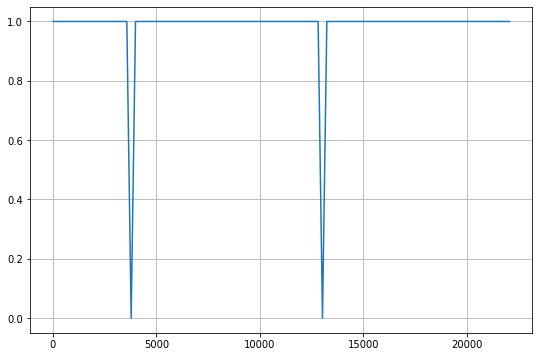

In [159]:
plt.figure(figsize=(9, 6))
plt.grid()
plt.plot([i * 30 * secondsPerAction for i in range(len(preds))], preds[:])